In [7]:
import ROOT

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm

In [2]:
a = { "1" : 18.8, "2" : 13 }
b = { "1" : 0.86, "2" : 1.12 }

MevToKev = 1e3
FWHMToSigma = 1 / 2.633

def get_reso( energy, key ):
    return np.sqrt( a[key] + b[key] * energy ) * FWHMToSigma

In [3]:
for file in glob("sim/*.root"):

    name = file.split( "/" )[1].split( "." )[0]

    events = { "Energy1" : [], "Energy2" : [] }

    f1 = ROOT.TFile( file )

    t1 = f1.Get( "EdepLaBr1" )
    t2 = f1.Get( "EdepLaBr2" )

    for idx in tqdm( range( t1.GetEntries( ) ) ):

        t1.GetEntry( idx )
        t2.GetEntry( idx )

        energy1 = getattr( t1, "LaBr1" ) * MevToKev
        energy2 = getattr( t2, "LaBr2" ) * MevToKev

        if( energy1 > 0 ): energy1 = np.random.normal( energy1, get_reso( energy1, "1" ) )
        if( energy2 > 0 ): energy2 = np.random.normal( energy2, get_reso( energy2, "2" ) )

        events["Energy1"].append( energy1 )
        events["Energy2"].append( energy2 )

    df = pd.DataFrame( events )
    df.to_pickle( "processed/{}.pkl".format(name) )

100%|██████████| 1000000/1000000 [00:02<00:00, 345625.87it/s]


/var/folders/13/_3g2lmwx6xl3zshjv1d7yz4c0000gn/T/ipykernel_69413/1229923088.py:19: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[0].set_yscale( "log" )
/var/folders/13/_3g2lmwx6xl3zshjv1d7yz4c0000gn/T/ipykernel_69413/1229923088.py:20: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[1].set_yscale( "log" )


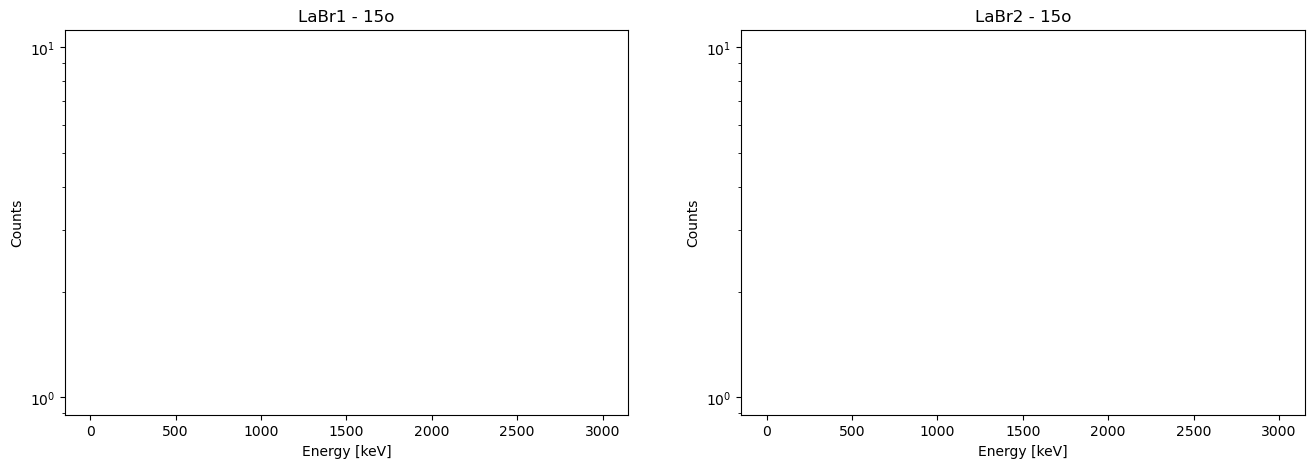

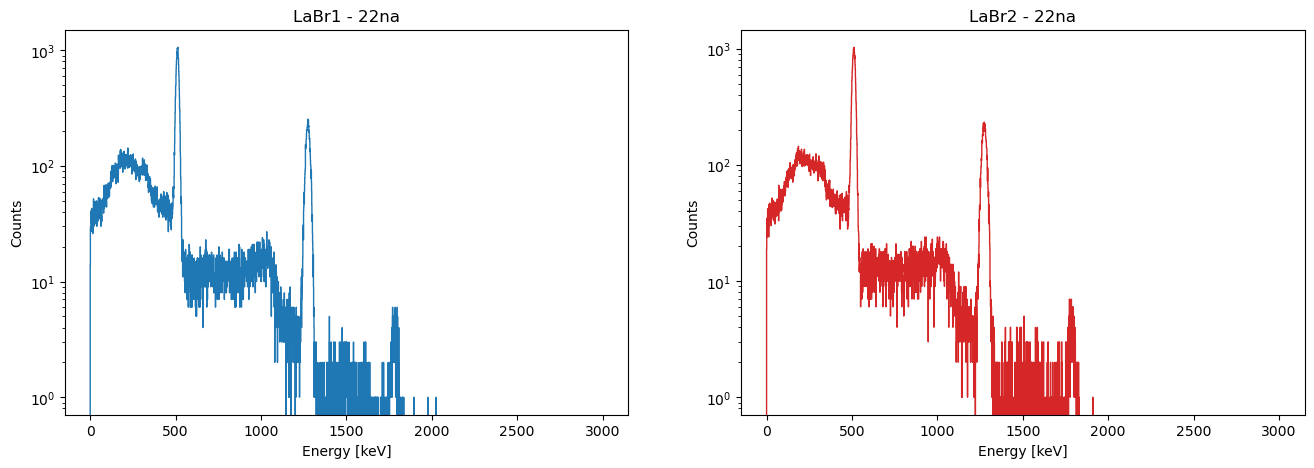

In [19]:
for file in glob("processed/*.pkl"):
    df = pd.read_pickle( file )

    mask1 = ( df["Energy1"] > 0 )
    mask2 = ( df["Energy2"] > 0 )

    # Plot histogram of LaBr1 and LaBr2
    fig, ax = plt.subplots( 1, 2, figsize=( 16, 5 ) )

    ax[0].hist( df["Energy1"][mask1], bins=3000, histtype="step", color="tab:blue", label="LaBr1", range=(0, 3000) )
    ax[1].hist( df["Energy2"][mask2], bins=3000, histtype="step", color="tab:red", label="LaBr2", range=(0, 3000) )

    ax[0].set_xlabel( "Energy [keV]" )
    ax[1].set_xlabel( "Energy [keV]" )

    ax[0].set_ylabel( "Counts" )
    ax[1].set_ylabel( "Counts" )

    ax[0].set_yscale( "log" )
    ax[1].set_yscale( "log" )

    ax[0].title.set_text( "LaBr1 - {}".format( file.split( "/" )[1].split( "." )[0] ) )
    ax[1].title.set_text( "LaBr2 - {}".format( file.split( "/" )[1].split( "." )[0] ) )

    plt.savefig( "plots/{}.png".format( file.split( "/" )[1].split( "." )[0] ) )

    plt.show( )

